## Thermal block problem -- data augmentation
**_Keywords: certified reduced basis method, scalar problem_**

### 1. Introduction
In this Tutorial, we consider steady heat conduction in a two-dimensional domain $\Omega$.

We define two subdomains $\Omega_1$ and $\Omega_2$, such that
1. $\Omega_1$ is a disk centered at the origin of radius $r_0=0.5$, and
2. $\Omega_2=\Omega/\ \overline{\Omega_1}$. 

The conductivity $\kappa$ is assumed to be constant on $\Omega_1$ and $\Omega_2$, i.e.
$$
\kappa|_{\Omega_1}=\kappa_0 \quad \textrm{and} \quad \kappa|_{\Omega_2}=1.
$$

For this problem, we consider $P=2$ parameters:
1. the first one is related to the conductivity in $\Omega_1$, i.e. $\mu_0\equiv k_0$ (_note that parameters numbering is zero-based_);
2. the second parameter $\mu_1$ takes into account the constant heat flux over $\Gamma_{base}$.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.1,10]\times[-1,1].
$$

In this problem we model the heat transfer process due to the heat flux over the bottom boundary $\Gamma_{base}$ and the following conditions on the remaining boundaries:
* the left and right boundaries $\Gamma_{side}$ are insulated,
* the top boundary $\Gamma_{top}$ is kept at a reference temperature (say, zero),

with the aim of measuring the average temperature on $\Gamma_{base}$.

In order to obtain a faster evaluation (yet, provably accurate) of the output of interest we propose to use a certified reduced basis approximation for the problem.

### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the temperature in the domain $\Omega$.

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that

$$
\begin{cases}
	- \text{div} (\kappa(\mu_0)\nabla u(\boldsymbol{\mu})) = 0 & \text{in } \Omega,\\
	u(\boldsymbol{\mu}) = 0 & \text{on } \Gamma_{top},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = 0 & \text{on } \Gamma_{side},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = \mu_1 & \text{on } \Gamma_{base}.
\end{cases}
$$
<br>

where 
* $\mathbf{n}$ denotes the outer normal to the boundaries $\Gamma_{side}$ and $\Gamma_{base}$,
* the conductivity $\kappa(\mu_0)$ is defined as follows:
$$
\kappa(\mu_0) =
\begin{cases}
	\mu_0 & \text{in } \Omega_1,\\
	1 & \text{in } \Omega_2,\\
\end{cases}
$$

The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H^1(\Omega) : v|_{\Gamma_{top}}=0\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \kappa(\mu_0)\nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \mu_1\int_{\Gamma_{base}}v \ ds.$$

The (compliant) output of interest $s(\boldsymbol{\mu})$ given by
$$s(\boldsymbol{\mu}) = \mu_1\int_{\Gamma_{base}} u(\boldsymbol{\mu})$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

For this problem the affine decomposition is straightforward:
$$a(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega_1}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)} \ + \  \underbrace{1}_{\Theta^{a}_1(\boldsymbol{\mu})}\underbrace{\int_{\Omega_2}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_1(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{\mu_1}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{base}}v \ ds}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class ThermalBlock(EllipticCoerciveCompliantProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
class ThermalBlock(EllipticCoerciveCompliantProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveCompliantProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)

    # Return custom problem name
    def name(self):
        return "ThermalBlock"

    # Return the alpha_lower bound.
    def get_stability_factor_lower_bound(self):
        return min(self.compute_theta("a"))

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[0]
            theta_a1 = 1.
            return (theta_a0, theta_a1)
        elif term == "f":
            theta_f0 = mu[1]
            return (theta_f0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = inner(grad(u), grad(v)) * dx(1)
            a1 = inner(grad(u), grad(v)) * dx(2)
            return (a0, a1)
        elif term == "f":
            ds = self.ds
            f0 = v * ds(1)
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 3)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/thermal_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/thermal_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/thermal_block_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the ThermalBlock class

In [5]:
problem = ThermalBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.1, 10.0), (-1.0, 1.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a reduced basis method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(10)
reduction_method.set_tolerance(1e-10)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(100)
reduced_problem = reduction_method.offline()

=                ThermalBlock POD-Galerkin offline phase begins                =

###################################### 0 #######################################
truth solve for mu = (5.533253688880515, 0.43037873274483895)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (6.067357423109274, 0.08976636599379373)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (4.294182513455157, 0.29178822613331223)
update snapshots matrix

###################################### 3 #######################################
truth solve for mu = (4.432113391500656, 0.7835460015641595)
update snapshots matrix

###################################### 4 #######################################
truth solve for mu = (9.64026132896019, -0.2331169623484446)
update snapshots matrix

###################################### 5 #######################################

truth solve for mu = (2.965120320177291, -0.6336172759857663)
update snapshots matrix

###################################### 48 ######################################
truth solve for mu = (5.906478054619823, -0.9597849076250129)
update snapshots matrix

###################################### 49 ######################################
truth solve for mu = (8.306506289251894, -0.9906090476149059)
update snapshots matrix

###################################### 50 ######################################
truth solve for mu = (6.810383714282678, -0.4599840536156703)
update snapshots matrix

###################################### 51 ######################################
truth solve for mu = (7.378420819013689, 0.9243770902348765)
update snapshots matrix

###################################### 52 ######################################
truth solve for mu = (2.562656120847585, 0.1523146688356738)
update snapshots matrix

###################################### 53 #################################

truth solve for mu = (1.9433107582153282, 0.8887447799678672)
update snapshots matrix

###################################### 97 ######################################
truth solve for mu = (7.421552870987947, -0.019082382764865846)
update snapshots matrix

###################################### 98 ######################################
truth solve for mu = (2.3514048169359003, -0.4912870364592141)
update snapshots matrix

###################################### 99 ######################################
truth solve for mu = (0.6744886872063686, -0.13116674888375845)
update snapshots matrix

################################# perform POD ##################################
lambda_0 = 95.7978523817353
lambda_1 = 3.7984245901485156
lambda_2 = 0.00030059849588982075
lambda_3 = 2.6799038385762646e-08

build reduced operators

=                 ThermalBlock POD-Galerkin offline phase ends                 =



#### 4.5.2 Initialize PDNN

In [14]:
input_normalization_pdnn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.MinMaxNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=20)
#pdnn_loss = Losses.Weighted_PDNN_Loss(pdnn_net, output_normalization_pdnn, epsilon=0.01)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.LambdaLR(
#    optimizer, lambda epoch: 0.9999**epoch
#)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

Initial training...
0 0.20335410224157163 	Loss(validation) = 0.23072905728898457
100 0.036525068530185854 	Loss(validation) = 0.10910171276854261
200 0.026721283767142577 	Loss(validation) = 0.0994768987956999
300 0.019129539932030436 	Loss(validation) = 0.09362752171199445
400 0.017559933317671927 	Loss(validation) = 0.09469978068971603
500 0.015179389499988672 	Loss(validation) = 0.09210930612534021
600 0.012079532043967384 	Loss(validation) = 0.08695352571775244
700 0.009920381253855725 	Loss(validation) = 0.0861268983399204
800 0.008312430222359043 	Loss(validation) = 0.08913337037052532
900 0.007101556948766524 	Loss(validation) = 0.09258972056079204
1000 0.006110973712126436 	Loss(validation) = 0.09511403419748572
1100 0.005252020985820398 	Loss(validation) = 0.09838772509836764
1200 0.004542764185737447 	Loss(validation) = 0.1028023537526235
1300 0.003996078043512962 	Loss(validation) = 0.10719329509799258
1400 0.003565008851594745 	Loss(validation) = 0.11055661870765184
1500 0

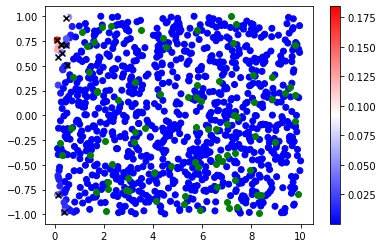

10000 0.16391756178739147 	Loss(validation) = 0.06998240887394103
10100 0.1397191443030446 	Loss(validation) = 0.07543650859768013
10200 0.12300597484314325 	Loss(validation) = 0.06454277244918476
10300 0.10936480708149746 	Loss(validation) = 0.054392437436215094
10400 0.09724640838157762 	Loss(validation) = 0.04786051937191237
10500 0.0861494098358391 	Loss(validation) = 0.04403701049189128
10600 0.0760995568369714 	Loss(validation) = 0.04151098012798718
10700 0.06696054896536775 	Loss(validation) = 0.03948559211536745
10800 0.05879728709543004 	Loss(validation) = 0.03830818073392292
10900 0.05166651658372834 	Loss(validation) = 0.038151323964082905
11000 0.045474468966596654 	Loss(validation) = 0.038804382472073774
11100 0.040070130621909124 	Loss(validation) = 0.03982595445838274
11200 0.03530831243586966 	Loss(validation) = 0.04074989975048737
11300 0.031067135975140693 	Loss(validation) = 0.041248229509670095
11400 0.02726165106427839 	Loss(validation) = 0.04115180879271193
11500 

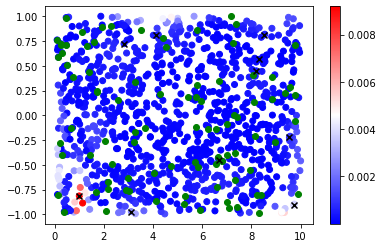

20000 0.000105661668448186 	Loss(validation) = 0.00042012049468535123
20100 9.472325728252677e-05 	Loss(validation) = 0.000448243909711769
20200 8.79172765287859e-05 	Loss(validation) = 0.00046589656850535834
20300 8.277983157535782e-05 	Loss(validation) = 0.0004751994915377153
20400 7.85723092350138e-05 	Loss(validation) = 0.00047966425156282453
20500 7.49662872743325e-05 	Loss(validation) = 0.00048176681306873567
20600 7.178240058976238e-05 	Loss(validation) = 0.0004829253141563607
20700 6.905268979487578e-05 	Loss(validation) = 0.00048437424792927583
20800 6.664667060308197e-05 	Loss(validation) = 0.0004843426474243909
20900 6.439587350267557e-05 	Loss(validation) = 0.0004852416910646272
21000 6.227051514189443e-05 	Loss(validation) = 0.0004863451360330704
21100 6.025004714517349e-05 	Loss(validation) = 0.00048769207134574997
21200 5.8420306698815026e-05 	Loss(validation) = 0.0004837844110627652
21300 5.669090895290276e-05 	Loss(validation) = 0.0004905171448699688
21400 5.5077974785

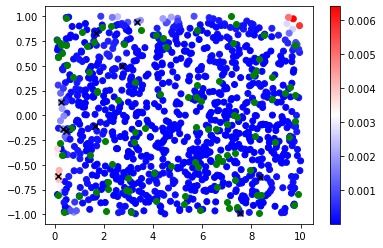

30000 0.0008811288646031461 	Loss(validation) = 0.0005327653999251711
30100 0.0007203207070911708 	Loss(validation) = 0.0005250777075438307
30200 0.0006115517041060494 	Loss(validation) = 0.0005217028571431017
30300 0.0005295104177408213 	Loss(validation) = 0.0005175518140130604
30400 0.00046420136384667585 	Loss(validation) = 0.0005116443614017011
30500 0.000410686805230724 	Loss(validation) = 0.0005034537688840621
30600 0.00036612472997090323 	Loss(validation) = 0.0004929671548057157
30700 0.000328692689791492 	Loss(validation) = 0.0004805653550176168
30800 0.00029710526316193325 	Loss(validation) = 0.00046680780812855574
30900 0.0002703516955702178 	Loss(validation) = 0.00045223051856657057
31000 0.0002475620284666199 	Loss(validation) = 0.0004372114143455904
31100 0.0002279709611727648 	Loss(validation) = 0.00042193695409939734
31200 0.00021093321562094965 	Loss(validation) = 0.00040645644241050545
31300 0.00019593903553924392 	Loss(validation) = 0.0003907652166201062
31400 0.00018

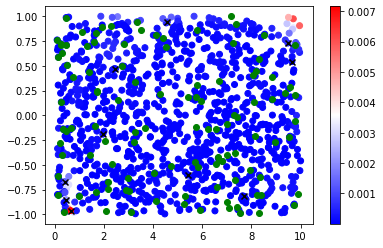

40000 0.0005274126845616552 	Loss(validation) = 0.00016466464304132526
40100 0.0003364108712176893 	Loss(validation) = 0.000294907341269735
40200 0.00024497331891220714 	Loss(validation) = 0.00037641590724305635
40300 0.0001938321175264368 	Loss(validation) = 0.0004265297683450122
40400 0.00016230179085716657 	Loss(validation) = 0.00045591242066716765
40500 0.0001413078129673609 	Loss(validation) = 0.0004714319626100481
40600 0.00012645741308761664 	Loss(validation) = 0.00047773788704034504
40700 0.00011545568091102511 	Loss(validation) = 0.000478021339740116
40800 0.00010701362016465764 	Loss(validation) = 0.00047446455459416537
40900 0.00010035526126290672 	Loss(validation) = 0.0004685431543448593
41000 9.498364813864289e-05 	Loss(validation) = 0.0004612408702181426
41100 9.056400764047402e-05 	Loss(validation) = 0.000453203259384904
41200 8.68620401649162e-05 	Loss(validation) = 0.00044484653201924934
41300 8.370919907402386e-05 	Loss(validation) = 0.000436433420909736
41400 8.09818

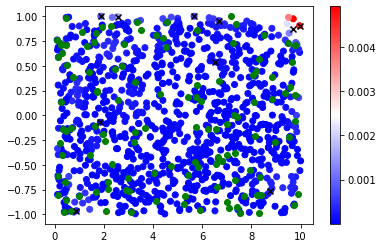

50000 4.767164222565067e-05 	Loss(validation) = 0.0001226090993837445
50100 4.577976829337534e-05 	Loss(validation) = 0.00011466126751798883
50200 4.4666292062134184e-05 	Loss(validation) = 0.00011011349014786043
50300 4.383138583902714e-05 	Loss(validation) = 0.00010677300764373363
50400 4.31449771561391e-05 	Loss(validation) = 0.00010404005025582625
50500 4.255171527348337e-05 	Loss(validation) = 0.000101693766155157
50600 4.202272588859241e-05 	Loss(validation) = 9.962935580043494e-05
50700 4.154104221519487e-05 	Loss(validation) = 9.778568595617386e-05
50800 4.109577585945124e-05 	Loss(validation) = 9.612153772016539e-05
50900 4.067945554915467e-05 	Loss(validation) = 9.460655332436552e-05
51000 4.028669459990734e-05 	Loss(validation) = 9.321721029106905e-05
51100 3.991346669250278e-05 	Loss(validation) = 9.193473640251024e-05
51200 3.955668152920565e-05 	Loss(validation) = 9.074387468158353e-05
51300 3.9213919147714434e-05 	Loss(validation) = 8.96320702278551e-05
51400 3.888325409

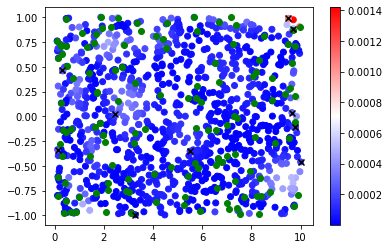

60000 5.804854116458227e-05 	Loss(validation) = 4.752960208807766e-05
60100 5.245129084445337e-05 	Loss(validation) = 4.705109348776179e-05
60200 4.987189943712746e-05 	Loss(validation) = 4.7219266125343696e-05
60300 4.832666560114412e-05 	Loss(validation) = 4.7543883119148544e-05
60400 4.725631221640808e-05 	Loss(validation) = 4.7942444528202465e-05
60500 4.643895943420023e-05 	Loss(validation) = 4.8382877411621106e-05
60600 4.5771021093004316e-05 	Loss(validation) = 4.88477730934307e-05
60700 4.51992842846761e-05 	Loss(validation) = 4.932638607263428e-05
60800 4.469445388778223e-05 	Loss(validation) = 4.981152937909663e-05
60900 4.4239366015818214e-05 	Loss(validation) = 5.029808747089706e-05
61000 4.3823306825433594e-05 	Loss(validation) = 5.078228777468114e-05
61100 4.3439137095529375e-05 	Loss(validation) = 5.126132966106853e-05
61200 4.30817861312347e-05 	Loss(validation) = 5.1733163323964224e-05
61300 4.27474402076841e-05 	Loss(validation) = 5.219632783154688e-05
61400 4.2433092

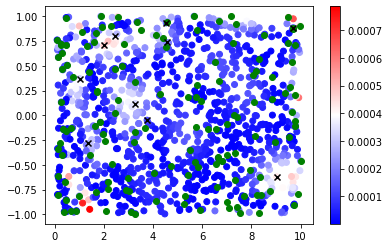

70000 3.4476962246670846e-05 	Loss(validation) = 6.313454987753798e-05
70100 3.430724943372212e-05 	Loss(validation) = 6.358642798284141e-05
70200 3.4184673838180624e-05 	Loss(validation) = 6.382976374903223e-05
70300 3.408146940576947e-05 	Loss(validation) = 6.398066502299897e-05
70400 3.39891210861031e-05 	Loss(validation) = 6.408710938058697e-05
70500 3.3903808391957416e-05 	Loss(validation) = 6.41704312988022e-05
70600 3.3823458230897005e-05 	Loss(validation) = 6.424047064727325e-05
70700 3.3746821744796705e-05 	Loss(validation) = 6.430196097443533e-05
70800 3.3673096888908166e-05 	Loss(validation) = 6.435731191893923e-05
70900 3.360174403554466e-05 	Loss(validation) = 6.440785122191871e-05
71000 3.35323855073305e-05 	Loss(validation) = 6.445438952949985e-05
71100 3.346474724091924e-05 	Loss(validation) = 6.449747944988279e-05
71200 3.339862358270604e-05 	Loss(validation) = 6.453753478964734e-05
71300 3.333385546521794e-05 	Loss(validation) = 6.457488605083304e-05
71400 3.327031655

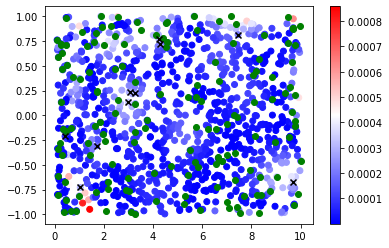

80000 3.320961216202901e-05 	Loss(validation) = 7.264646067544149e-05
80100 3.302462581347763e-05 	Loss(validation) = 7.41995287517491e-05
80200 3.291866437997168e-05 	Loss(validation) = 7.512833993386348e-05
80300 3.284541745097123e-05 	Loss(validation) = 7.578141870086959e-05
80400 3.2789529801174686e-05 	Loss(validation) = 7.62733831582202e-05
80500 3.2744007065411275e-05 	Loss(validation) = 7.665742302009054e-05
80600 3.2705160389093526e-05 	Loss(validation) = 7.696383016963508e-05
80700 3.267085983673475e-05 	Loss(validation) = 7.721194144682152e-05
80800 3.26397927152864e-05 	Loss(validation) = 7.74149812325534e-05
80900 3.261110845149996e-05 	Loss(validation) = 7.758242856941988e-05
81000 3.258423348377776e-05 	Loss(validation) = 7.772131576378123e-05
81100 3.2558768189394815e-05 	Loss(validation) = 7.783699636479714e-05
81200 3.253442636485651e-05 	Loss(validation) = 7.793362595043981e-05
81300 3.251099811525203e-05 	Loss(validation) = 7.801447818715108e-05
81400 3.248832627015

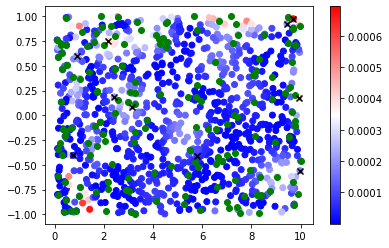

90000 3.1104344996196994e-05 	Loss(validation) = 7.615765292119538e-05
90100 3.10824474056554e-05 	Loss(validation) = 7.622200907551262e-05
90200 3.106599863562992e-05 	Loss(validation) = 7.627937081012359e-05
90300 3.105215162052875e-05 	Loss(validation) = 7.632549230903834e-05
90400 3.103989428021586e-05 	Loss(validation) = 7.636393092111006e-05
90500 3.102872168175097e-05 	Loss(validation) = 7.639649063832285e-05
90600 3.101833812500604e-05 	Loss(validation) = 7.642417203558143e-05
90700 3.1008552744136356e-05 	Loss(validation) = 7.644764218507861e-05
90800 3.099923428998346e-05 	Loss(validation) = 7.6467413253017e-05
90900 3.099028862994082e-05 	Loss(validation) = 7.648391220847548e-05
91000 3.098164633106354e-05 	Loss(validation) = 7.649751090910857e-05
91100 3.0973255218178314e-05 	Loss(validation) = 7.65085408337988e-05
91200 3.0965075598715485e-05 	Loss(validation) = 7.65173011628704e-05
91300 3.09570770217704e-05 	Loss(validation) = 7.652406356520203e-05
91400 3.09492359796228

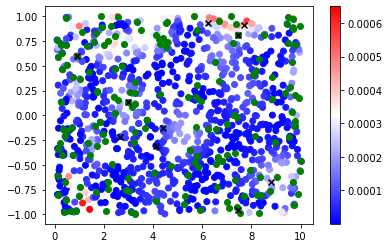

100000 2.9743316872897943e-05 	Loss(validation) = 7.588942419585709e-05
100100 2.9734995200002675e-05 	Loss(validation) = 7.586080085263504e-05
100200 2.9729059136597376e-05 	Loss(validation) = 7.585379981707102e-05
100300 2.9724132993827097e-05 	Loss(validation) = 7.585358190742018e-05
100400 2.9719783270012192e-05 	Loss(validation) = 7.585610861894653e-05
100500 2.9715813600788252e-05 	Loss(validation) = 7.585960026380645e-05
100600 2.9712116706441863e-05 	Loss(validation) = 7.586323224039035e-05
100700 2.9708626681942726e-05 	Loss(validation) = 7.586664177185385e-05
100800 2.9705299699834134e-05 	Loss(validation) = 7.586968994910896e-05
100900 2.9702104936932087e-05 	Loss(validation) = 7.587234145694076e-05
101000 2.9699019815921725e-05 	Loss(validation) = 7.587460488458723e-05
101100 2.9696027289892197e-05 	Loss(validation) = 7.587650442811389e-05
101200 2.9693114184777565e-05 	Loss(validation) = 7.587806747016484e-05
101300 2.969027013177701e-05 	Loss(validation) = 7.5879319884942

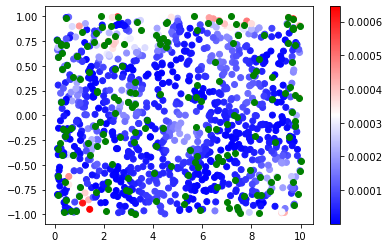

In [15]:
import matplotlib.pyplot as plt
n = 1000 # number of parameters for which we compute residuals each iteration
num_new_params = 10 # number of parameters with which we augment data each iteration
assert num_new_params <= n

# train PDNN
print("Initial training...")
pdnn_trainer.train()

new_parameters = pdnn_net.augment_parameters_with_time(
        RONNData.get_new_parameters(pdnn_net, n)
)

print("Assembling residuals...")
residuals, _, loss_functions = ErrorAnalysis.get_residuals(
    pdnn_net, data, new_parameters, 
    input_normalization_pdnn, output_normalization_pdnn,
    plot_residuals=True
)


print("Beginning data augmentation cycles...")
for i in range(10):
    #sort_indices = np.argsort(-residuals)
    #high_residual_params = new_parameters[sort_indices[:num_new_params]]
    #print(high_residual_params)
    
    
    probabilities = residuals
    probabilities /= np.sum(probabilities)
    sample_indices = np.random.choice(residuals.shape[0], size=residuals.shape[0],
                                      replace=False, p=probabilities)
    cumulative_probs = np.cumsum(probabilities[sample_indices])
    last_index = np.searchsorted(cumulative_probs, 0.25) + 1
    sample_indices = sample_indices[:num_new_params]#sample_indices[:last_index]
    high_residual_params = new_parameters[sample_indices]
    plt.scatter(high_residual_params[:, 0].numpy().reshape(-1), 
                high_residual_params[:, 1].numpy().reshape(-1), marker='x', color='black')
    
    plt.show()
    
    # solve reduced PDE system for parameters found above and augment training data
    for j, mu in enumerate(high_residual_params):
        reduced_problem.set_mu(tuple(np.array(mu)))
        reduced_problem.solve()
        solution = torch.tensor(np.array(reduced_problem._solution.vector()[:])).view(-1, 1)
        pdnn_loss.concatenate_snapshots(solution)
        
    data.train_data = torch.cat([data.train_data, high_residual_params])
    
    # train PDNN
    pdnn_trainer.train()
    
    residuals, _, _ = ErrorAnalysis.get_residuals(
        pdnn_net, data, new_parameters, 
        input_normalization_pdnn, output_normalization_pdnn,
        loss_functions, plot_residuals=True
    )

In [ ]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [ ]:
reduction_method.initialize_testing_set(100)
reduction_method.error_analysis()

#### 4.6.2 PDNN Error Analysis

In [ ]:
test_mu = torch.tensor(reduction_method.testing_set)

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn, euclidean=True
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, (8.0, -1.0), input_normalization_pdnn, output_normalization_pdnn, colorbar=True
)

In [ ]:
pdnn_loss.proj_snapshots.shape

In [ ]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.)

pdnn_net.apply(init_weights)

pdnn_trainer.lr_scheduler = None
pdnn_trainer.optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
pdnn_trainer.train()

In [ ]:
pdnn_trainer.optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.00001)
pdnn_trainer.train()

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn, euclidean=False
)

In [ ]:
rb_coefficients = []
for mu in reduction_method.testing_set:
    reduced_problem.set_mu(mu)
    reduced_problem.solve()
    rb_coefficients.append(np.array(reduced_problem._solution.vector()[:]))
rb_coefficients = np.array(rb_coefficients).T

In [ ]:
u, s, vh = np.linalg.svd(rb_coefficients, full_matrices=False)

In [ ]:
np.allclose(rb_coefficients, u @ np.diag(s) @ vh)

In [ ]:
rb_coefficients.shape, u.shape, s.shape, vh.shape

In [ ]:
reduction_method.initialize_testing_set(10000)
rb_coefficients = []
for mu in reduction_method.testing_set:
    reduced_problem.set_mu(mu)
    reduced_problem.solve()
    rb_coefficients.append(np.array(reduced_problem._solution.vector()[:]))
rb_coefficients = np.array(rb_coefficients).T

for i in range(rb_coefficients.shape[0]):
    mus = np.array(reduction_method.testing_set)
    plt.scatter(mus[:, 0], mus[:, 1], c=rb_coefficients[i])
    plt.colorbar()
    plt.show()

In [8]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
# make training data
reduction_method.initialize_testing_set(200)

X = np.array(reduction_method.testing_set)
X_std = (X - np.mean(X, axis=0, keepdims=True))/np.std(X, axis=0, keepdims=True)
X_std = torch.tensor(X_std)

Y = []
for mu in reduction_method.testing_set:
    reduced_problem.set_mu(mu)
    reduced_problem.solve()
    Y.append(np.array(reduced_problem._solution.vector()[:]))
Y = np.array(Y).T
Y_std = (Y - np.mean(Y, axis=1, keepdims=True))/np.std(Y, axis=1, keepdims=True)

In [10]:
C1Net = Net()
C2Net = Net()
C3Net = Net()
C4Net = Net()

nets = [C1Net, C2Net, C3Net, C4Net]

In [11]:
for c in range(4):
    print("Training net", c)
    net = nets[c]
    Y1 = torch.tensor(Y_std[[c]]).T
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

    for e in range(10000):
        Y1_ = net(X_std)
        loss = loss_fn(Y1_, Y1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        if e % 100 == 0:
            print(e, loss.item())
    print("\n\n\n")

Training net 0
0 1.1057305991067032
100 0.10736817272034596
200 0.018681899548341055
300 0.014249680072053206
400 0.011550306930199957
500 0.009949138429255506
600 0.008890975805653926
700 0.008066563445174337
800 0.007367097718616139
900 0.006756525261973354
1000 0.006214250373384281
1100 0.005724670798150486
1200 0.005277047505809176
1300 0.004865150992350124
1400 0.004485945477981929
1500 0.004138078063569004
1600 0.0038207408035941547
1700 0.003533082158204276
1800 0.0032740463933968373
1900 0.003042415308193233
2000 0.0028368816529843583
2100 0.002656082585093391
2200 0.002498585937538731
2300 0.0023628461146031924
2400 0.002247151669088479
2500 0.002149585709693257
2600 0.002068015427633589
2700 0.0020001183708004047
2800 0.0019434424505510412
2900 0.001895487288706488
3000 0.001853789600428542
3100 0.001815996553547825
3200 0.0017799178246743859
3300 0.0017435564856207093
3400 0.0017051263606347388
3500 0.0016630643910545727
3600 0.0016160399618894647
3700 0.001562959591586035
3

700 0.5257847558659781
800 0.512130105933738
900 0.4971174022965886
1000 0.48028809088165986
1100 0.4614639084050359
1200 0.4409793631178172
1300 0.417223434327904
1400 0.3783370825963427
1500 0.30547821171064515
1600 0.24034251643650234
1700 0.1893054730779755
1800 0.15257661889472485
1900 0.1273059830460461
2000 0.10794034111756265
2100 0.09217113665824644
2200 0.07883526834789549
2300 0.06723882030040544
2400 0.05710934997448465
2500 0.0489328384508956
2600 0.04208870345447796
2700 0.0363491877980411
2800 0.031503503366191024
2900 0.02731825680048737
3000 0.023607637931249946
3100 0.020292498488291403
3200 0.01734429945722089
3300 0.014745588345759137
3400 0.012479699606647618
3500 0.010527283099459873
3600 0.008864145581937837
3700 0.0074575847062545745
3800 0.0062746435696608895
3900 0.005281739037873936
4000 0.004451184051239409
4100 0.003757780222103576
4200 0.0031805539150091666
4300 0.0027014686270482625
4400 0.002305287334137135
4500 0.0019778826733702908
4600 0.0017075831277

In [12]:
reduction_method.initialize_testing_set(1000)

X_test = np.array(reduction_method.testing_set)
X_std = (X_test - np.mean(X, axis=0, keepdims=True))/np.std(X, axis=0, keepdims=True)
X_std = torch.tensor(X_std)

Y_test = []
for mu in reduction_method.testing_set:
    reduced_problem.set_mu(mu)
    reduced_problem.solve()
    Y_test.append(np.array(reduced_problem._solution.vector()[:]))
Y_test = np.array(Y_test).T


pred1 = C1Net(X_std).detach().numpy().T * np.std(Y[[0]], axis=1, keepdims=True) + np.mean(Y[[0]], axis=1, keepdims=True)
pred2 = C2Net(X_std).detach().numpy().T * np.std(Y[[1]], axis=1, keepdims=True) + np.mean(Y[[1]], axis=1, keepdims=True)
pred3 = C3Net(X_std).detach().numpy().T * np.std(Y[[2]], axis=1, keepdims=True) + np.mean(Y[[2]], axis=1, keepdims=True)
pred4 = C4Net(X_std).detach().numpy().T * np.std(Y[[3]], axis=1, keepdims=True) + np.mean(Y[[3]], axis=1, keepdims=True)

pred = np.vstack([pred1, pred2, pred3, pred4])

In [13]:
coeff = pdnn_net.get_coefficient_matrix().detach().numpy()

NameError: name 'pdnn_net' is not defined

In [ ]:
np.mean(np.linalg.norm(coeff@(Y_test - pred), axis=0) / np.linalg.norm(coeff@Y_test, axis=0))